# Descarga del Dataset

In [ ]:
import sys, subprocess, pkgutil

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

req = ["pandas","numpy","scikit-learn","matplotlib","nltk","gensim","textdistance","spacy","datasets"]
to_install = [p for p in req if pkgutil.find_loader(p) is None]
if to_install:
    pip_install(to_install)

try:
    import es_core_news_sm
except Exception:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])

import nltk
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

print("OK: dependencias listas.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caste\AppData\Roaming\nltk_data...


OK: dependencias listas.


[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
import pandas as pd, os

os.makedirs("data/raw", exist_ok=True)
df = pd.read_csv("data/raw/data.csv")

print("Columnas:", df.columns.tolist())
text_candidates  = [c for c in ["text","content","article","body","news","texto"] if c in df.columns]
label_candidates = [c for c in ["label","category","topic","class","etiqueta"] if c in df.columns]

if not text_candidates or not label_candidates:
    raise ValueError("No encuentro columnas de texto/etiqueta. Dime qué columnas trae y lo ajusto.")

TEXT_COL  = text_candidates[0]
LABEL_COL = label_candidates[0]

out = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"text", LABEL_COL:"label"})
out.to_csv("data/raw/dataset.csv", index=False)
print("Listo -> data/raw/dataset.csv", out.shape)
print(out.head(3))

Columnas: ['language', 'category', 'newspaper', 'hash', 'text']
Listo -> data/raw/dataset.csv (10200, 2)
                                                text label
0  Valladolid misteriosa es el título del nuevo l...  play
1  El coraje de ser, de Mónica Cavallé, la aventu...  play
2  En la Tercera el francés, de Federico Supervie...  play


# Preprocesamiento

In [ ]:
import sys, subprocess, pkgutil

def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    if pkgutil.find_loader(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])

ensure("pandas")
ensure("numpy")
ensure("nltk")
ensure("textdistance")
try:
    ensure("spacy")
    import spacy
    try:
        import es_core_news_sm 
        nlp = es_core_news_sm.load()
    except Exception:
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])
        import es_core_news_sm
        nlp = es_core_news_sm.load()
except Exception:
    nlp = None

import nltk
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

print("OK deps. spaCy:", "on" if nlp else "off")

OK deps. spaCy: on


In [ ]:
import pandas as pd, os

path = "data/raw/dataset.csv"  
df = pd.read_csv(path)
assert {"text","label"}.issubset(df.columns), df.columns.tolist()

df = df.dropna(subset=["text"]).reset_index(drop=True)
print(df.shape)
df.head(3)

(10200, 2)


,text,label
0,Valladolid misteriosa es el título del nuevo l...,play
1,"El coraje de ser, de Mónica Cavallé, la aventu...",play
2,"En la Tercera el francés, de Federico Supervie...",play


In [ ]:
import re, unicodedata
from nltk.corpus import stopwords

SPANISH_SW = set(stopwords.words("spanish"))

def normalize(txt:str)->str:
    txt = txt.lower()
    txt = "".join(c for c in unicodedata.normalize("NFD", txt) if unicodedata.category(c) != "Mn")
    txt = re.sub(r"[\r\n\t]+"," ", txt)
    txt = re.sub(r"\s+"," ", txt).strip()
    return txt

def tokenize_simple(txt:str):
    return re.findall(r"\b\w+\b", txt, flags=re.UNICODE)

def clean_tokens(tokens, remove_digits=True, remove_sw=True):
    out=[]
    for t in tokens:
        if remove_digits and t.isdigit(): 
            continue
        if remove_sw and t in SPANISH_SW:
            continue
        out.append(t)
    return out

In [ ]:
df["text_norm"] = df["text"].map(normalize)
df["tokens"] = df["text_norm"].map(tokenize_simple).map(clean_tokens)

print(df[["text", "text_norm"]].head(2))
print("Ejemplo tokens:", df["tokens"].iloc[0][:20])

                                                text  \
0  Valladolid misteriosa es el título del nuevo l...   
1  El coraje de ser, de Mónica Cavallé, la aventu...   

                                           text_norm  
0  valladolid misteriosa es el titulo del nuevo l...  
1  el coraje de ser, de monica cavalle, la aventu...  
Ejemplo tokens: ['valladolid', 'misteriosa', 'titulo', 'nuevo', 'libro', 'acaba', 'publicar', 'editorial', 'almuzara', 'trata', 'obra', 'investigador', 'paranormal', 'juan', 'carlos', 'pasalodos', 'perez', 'realiza', 'exhaustiva', 'recopilacion']


In [ ]:
from nltk.stem.snowball import SpanishStemmer
stemmer = SpanishStemmer()

df["stems"] = df["tokens"].map(lambda toks: [stemmer.stem(t) for t in toks])

if nlp is not None:
    def lemmatize_list(toks):
        doc = nlp(" ".join(toks))
        return [t.lemma_ if t.lemma_ else t.text for t in doc]
    df["lemmas"] = df["tokens"].map(lemmatize_list)
else:
    df["lemmas"] = df["tokens"] 

df[["tokens","stems","lemmas"]].head(2)

,tokens,stems,lemmas
0,"[valladolid, misteriosa, titulo, nuevo, libro,...","[valladol, misteri, titul, nuev, libr, acab, p...","[valladolid, misterioso, titulo, nuevo, libro,..."
1,"[coraje, ser, monica, cavalle, aventura, autoc...","[coraj, ser, monic, cavall, aventur, autoconoc...","[coraje, ser, monicar, cavalle, aventura, auto..."


In [ ]:
from collections import Counter
import textdistance

vocab = Counter(t for toks in df["tokens"] for t in toks)
rare = [w for w,c in vocab.items() if c==1][:100]    
cand = set([w for w,c in vocab.items() if c>=5])      

def suggest(word, candidates, max_dist=1):
    return [c for c in candidates if textdistance.levenshtein.distance(word, c) <= max_dist]

for w in rare[:10]:
    s = suggest(w, cand, max_dist=1)
    if s:
        print(f"{w} -> {s[:5]}")

arcanos -> ['arcano']
asentamos -> ['sentamos', 'asentados']
yoes -> ['oes', 'goes', 'yves', 'does']
llenados -> ['llegados', 'llenamos', 'llenado', 'llevados']
azores -> ['amores']


In [ ]:
os.makedirs("data/processed", exist_ok=True)
df.to_parquet("data/processed/preprocesado.parquet", index=False)
print("OK → data/processed/preprocesado.parquet")

OK → data/processed/preprocesado.parquet


# Representaciones

In [1]:
import sys, subprocess, pkgutil, os

def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    if pkgutil.find_loader(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])

ensure("pandas")
ensure("numpy")
ensure("scikit-learn", "scikit-learn")
ensure("gensim")
ensure("matplotlib")

import numpy as np, pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

print("OK imports.")


OK imports.


In [2]:
df = pd.read_parquet("data/processed/preprocesado.parquet")
texts  = df["text_norm"].tolist()
tokens = df["tokens"].tolist()
len(texts), len(tokens), type(tokens[0])[:5]

(10200, 10200, numpy.ndarray[slice(None, 5, None)])

In [ ]:
bow = CountVectorizer(ngram_range=(1,1))          
tfidf = TfidfVectorizer(ngram_range=(1,2))        

X_bow   = bow.fit_transform(texts)
X_tfidf = tfidf.fit_transform(texts)

print("BoW:",   X_bow.shape,   "Voc:", len(bow.vocabulary_))
print("TF-IDF:", X_tfidf.shape, "Voc:", len(tfidf.vocabulary_))

import joblib
joblib.dump(bow,   "models/bow_vectorizer.joblib")
joblib.dump(tfidf, "models/tfidf_vectorizer.joblib")

BoW: (10200, 157587) Voc: 157587
TF-IDF: (10200, 1921725) Voc: 1921725


['models/tfidf_vectorizer.joblib']

In [ ]:
import numpy as np, pickle, os, ast
from collections import Counter

if isinstance(tokens[0], str):
    tokens = [ast.literal_eval(t) for t in tokens]

def cooc_matrix(tokenized_docs, window=4, min_count=5, top_k=None):
    vocab_counts = Counter(t for doc in tokenized_docs for t in doc)
    items = [(w,c) for w,c in vocab_counts.items() if c >= min_count]
    if top_k is not None and len(items) > top_k:
        items = sorted(items, key=lambda x: -x[1])[:top_k]
    idx = {w:i for i,(w,_) in enumerate(sorted(items, key=lambda x: -x[1]))}
    V = len(idx)
    C = np.zeros((V, V), dtype=np.float32)
    for doc in tokenized_docs:
        L = len(doc)
        for i, t in enumerate(doc):
            if t not in idx: 
                continue
            wi = idx[t]
            left = max(0, i - window)
            right = min(L, i + window + 1)
            for u in doc[left:i]:
                if u in idx:
                    C[wi, idx[u]] += 1.0
            for u in doc[i+1:right]:
                if u in idx:
                    C[wi, idx[u]] += 1.0
    return C, idx

def ppmi(C, eps=1e-8):
    total = C.sum()
    if total == 0:
        return C
    pi = C.sum(axis=1, keepdims=True)
    pj = C.sum(axis=0, keepdims=True)
    pij = C / (total + eps)
    denom = (pi @ pj) / (total**2 + eps)
    with np.errstate(divide='ignore'):
        pmi = np.log((pij + eps) / (denom + eps))
    return np.maximum(0.0, pmi)

C, idx = cooc_matrix(tokens, window=4, min_count=5, top_k=20000)
X_ppmi = ppmi(C)

print("Co-ocurrencias:", C.shape, "| PPMI:", X_ppmi.shape, "| Vocab:", len(idx))

os.makedirs("data/processed", exist_ok=True)
np.save("data/processed/cooc.npy", C)
np.save("data/processed/ppmi.npy", X_ppmi)
with open("data/processed/cooc_idx.pkl", "wb") as f:
    pickle.dump(idx, f)
print("OK → cooc/ppmi guardados.")

Co-ocurrencias: (20000, 20000) | PPMI: (20000, 20000) | Vocab: 20000
OK → cooc/ppmi guardados.


In [ ]:
# Celda 5 (FIX) — Word2Vec robusto + progreso + guardado
import os, numpy as np
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

def clean_docs(docs, min_len=2):
    ok = []
    for doc in docs:
        if isinstance(doc, str):
            seq = doc.split()
        elif isinstance(doc, (list, tuple)):
            seq = list(doc)
        else:
            try:
                seq = list(doc)
            except Exception:
                continue
        clean = []
        for t in seq:
            if t is None:
                continue
            if isinstance(t, (list, tuple, np.ndarray, dict, set)):
                continue
            s = str(t).strip()
            if s:
                clean.append(s)
        if len(clean) >= min_len:
            ok.append(clean)
    return ok

tokens_clean = clean_docs(tokens, min_len=2)
print("Docs totales:", len(tokens), "| docs válidos:", len(tokens_clean))
print("Ejemplo doc:", tokens_clean[0][:12])

class EpochLogger(CallbackAny2Vec):
    def __init__(self): self.epoch = 0
    def on_epoch_begin(self, model): 
        print(f"▶️  epoch {self.epoch+1}/{model.epochs}")
    def on_epoch_end(self, model):
        if model.compute_loss:
            print(f"   loss acumulado: {model.get_latest_training_loss():.1f}")
        self.epoch += 1

w2v = Word2Vec(
    vector_size=100, window=5, min_count=5,
    workers=2, sg=1, epochs=5, seed=42,
    compute_loss=True
)

w2v.build_vocab(tokens_clean, progress_per=10000)
print("Vocab size:", len(w2v.wv))

w2v.train(
    corpus_iterable=tokens_clean,
    total_examples=w2v.corpus_count,
    epochs=w2v.epochs,
    report_delay=10,
    callbacks=[EpochLogger()]
)

def doc_avg_vecs(tokenized_docs, model):
    dim = model.wv.vector_size
    out = []
    for doc in tokenized_docs:
        vecs = [model.wv[w] for w in doc if w in model.wv]
        out.append(np.mean(vecs, axis=0) if len(vecs) else np.zeros(dim))
    return np.vstack(out)

X_w2v = doc_avg_vecs(tokens_clean, w2v)
print("Doc-embeddings:", X_w2v.shape)

os.makedirs("models", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
w2v.save("models/word2vec.model")
np.save("data/processed/doc_embeddings_w2v.npy", X_w2v)
print("OK → models/word2vec.model y data/processed/doc_embeddings_w2v.npy")

Docs totales: 10200 | docs válidos: 10200
Ejemplo doc: ['valladolid', 'misteriosa', 'titulo', 'nuevo', 'libro', 'acaba', 'publicar', 'editorial', 'almuzara', 'trata', 'obra', 'investigador']
Vocab size: 50606
▶️  epoch 1/5
▶️  epoch 2/5
▶️  epoch 3/5
▶️  epoch 4/5
▶️  epoch 5/5
Doc-embeddings: (10200, 100)
OK → models/word2vec.model y data/processed/doc_embeddings_w2v.npy


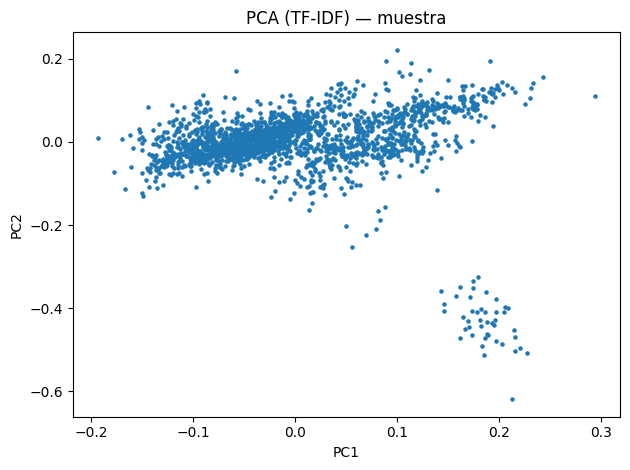

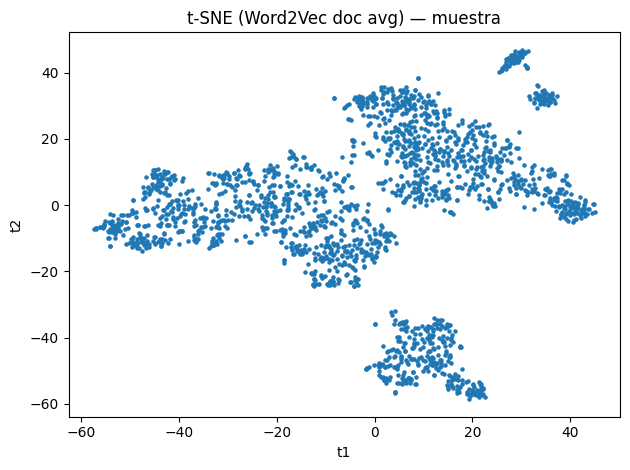

Figuras guardadas en ./figures/


In [ ]:
n1 = min(2000, X_tfidf.shape[0])
n2 = min(2000, X_w2v.shape[0])

X_tfidf_sample = X_tfidf[:n1].toarray()
pca = PCA(n_components=2, random_state=42).fit_transform(X_tfidf_sample)
plt.figure()
plt.scatter(pca[:,0], pca[:,1], s=5)
plt.title("PCA (TF-IDF) — muestra")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.savefig("figures/pca_tfidf.png", dpi=160)
plt.show()

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="random").fit_transform(X_w2v[:n2])
plt.figure()
plt.scatter(tsne[:,0], tsne[:,1], s=5)
plt.title("t-SNE (Word2Vec doc avg) — muestra")
plt.xlabel("t1"); plt.ylabel("t2")
plt.tight_layout(); plt.savefig("figures/tsne_w2v.png", dpi=160)
plt.show()

print("Figuras guardadas en ./figures/")

In [ ]:
print({
    "bow_shape":   tuple(X_bow.shape),
    "tfidf_shape": tuple(X_tfidf.shape),
    "ppmi_shape":  tuple(X_ppmi.shape),
    "w2v_docs":    X_w2v.shape[0],
    "w2v_dim":     X_w2v.shape[1],
})

{'bow_shape': (10200, 157587), 'tfidf_shape': (10200, 1921725), 'ppmi_shape': (20000, 20000), 'w2v_docs': 10200, 'w2v_dim': 100}
